# Transformer-Based CSI Activity Recognition Model
---
This notebook implements a **Transformer-based model** for classifying human activities using Channel State Information (CSI) data. 
We aim to leverage the self-attention mechanism of Transformers to capture long-range dependencies, which is crucial for 
WiFi CSI signals that span over multiple time frames. This model is an improvement over traditional RNN-based approaches 
like BiLSTM by handling sequential data in a parallelized and memory-efficient way.


## 1. Imports

In [6]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, MultiHeadAttention, GlobalAveragePooling1D, Add
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import os

## 2. Load Data

In [8]:
import os
import numpy as np

# Data directory
data_dir = '/Users/lordram/Library/CloudStorage/OneDrive-DeakinUniversity/Master of IT/SIT764 - Team Project A - Project Management and Practices/Gopher/Room2_npy'

X, y = [], []
classes = sorted(os.listdir(data_dir))

print("Classes found:", classes) 

for label_index, activity in enumerate(classes):
    activity_folder = os.path.join(data_dir, activity)

    # Skip non-directories and system files
    if activity.startswith('.') or not os.path.isdir(activity_folder):
        continue

    for file in os.listdir(activity_folder):
        if file.endswith('.npy'):
            file_path = os.path.join(activity_folder, file)
            sample = np.load(file_path)

            # Accept if sample has at least 750 time steps
            if sample.shape[0] >= 750:
                sample = sample[:750, :]  # Trim to 750 time steps
                X.append(sample)
                y.append(label_index)
                #print("Loaded:", file_path, "Trimmed Shape:", sample.shape)

# Convert to arrays
X = np.array(X)
y = np.array(y)

print("Loaded samples:", len(X))
print("Loaded labels:", len(y))
print("Final X shape:", X.shape)


Classes found: ['.DS_Store', 'kneel', 'liedown', 'pickup', 'sit', 'sitrotate', 'stand', 'standrotate', 'walk']
Loaded samples: 114
Loaded labels: 114
Final X shape: (114, 750, 90)


## 3. Encode Labels

In [10]:
encoder = OneHotEncoder(sparse_output=False)
y_encoded = encoder.fit_transform(y.reshape(-1, 1))

## 4. Train-Test Split

In [12]:
X_train, X_test, y_train_encoded, y_test_encoded = train_test_split(
    X, y_encoded,
    test_size=0.2,
    random_state=42
)

## 5. Positional Encoding Layer

In [14]:
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, max_len, d_model):
        super().__init__()
        pos = tf.range(max_len)[:, tf.newaxis]
        i = tf.range(d_model)[tf.newaxis, :]
        i = tf.cast(i, tf.float32)  # ✅ Fix: match dtype with d_model
        angle_rates = 1 / tf.pow(10000.0, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        angle_rads = tf.cast(pos, tf.float32) * angle_rates

        sines = tf.sin(angle_rads[:, 0::2])
        cosines = tf.cos(angle_rads[:, 1::2])
        self.pos_encoding = tf.concat([sines, cosines], axis=-1)[tf.newaxis, ...]

    def call(self, x):
        return x + self.pos_encoding[:, :tf.shape(x)[1], :]


## 6. Building the Transformer Architecture

In [16]:
def build_csi_transformer(seq_len=750, feature_dim=90, num_classes=8, d_model=128, num_heads=4):
    inputs = Input(shape=(seq_len, feature_dim))
    x = Dense(d_model)(inputs)
    x = PositionalEncoding(seq_len, d_model)(x)

    attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=d_model)(x, x)
    x = Add()([x, attn_output])
    x = LayerNormalization()(x)

    ff = Dense(128, activation='relu')(x)
    x = Add()([x, ff])
    x = LayerNormalization()(x)

    x = GlobalAveragePooling1D()(x)
    x = Dense(64, activation='relu')(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model


## 7. Build and Compile Model

In [18]:
model = build_csi_transformer()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#Add EarlyStopping + ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1
)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 750, 90)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 750, 128)  │     11,648 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_encoding │ (None, 750, 128)  │          0 │ dense[0][0]       │
│ (PositionalEncodin… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 750, 128)  │    263,808 │ positional_encod… │
│ (MultiHeadAttentio… │                   │            │ positional_encod… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 750, 128)  │          0 │ positional_encod… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 750, 128)  │        256 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 750, 128)  │     16,512 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 750, 128)  │          0 │ layer_normalizat… │
│                     │                   │            │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 750, 128)  │        256 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │      8,256 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 8)         │        520 │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 301,256 (1.15 MB)

 Trainable params: 301,256 (1.15 MB)

 Non-trainable params: 0 (0.00 B)

Note: Add EarlyStopping + ReduceLROnPlateau helps the model stop early if it overfits, and adjusts learning rate dynamically.

## 8. Train the Model

In [20]:
history = model.fit(X_train, y_train_encoded,
    validation_split=0.2,
    epochs=50,
    batch_size=2,
    callbacks=[early_stopping, reduce_lr])

Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.2341 - loss: 2.0546WARNING:tensorflow:You are casting an input of type complex64 to an incompatible dtype float32.  This will discard the imaginary part and may not be what you intended.
36/36 ━━━━━━━━━━━━━━━━━━━━ 9s 150ms/step - accuracy: 0.2357 - loss: 2.0518 - val_accuracy: 0.2105 - val_loss: 2.1482 - learning_rate: 0.0010
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - accuracy: 0.4675 - loss: 1.7644 - val_accuracy: 0.3158 - val_loss: 2.1973 - learning_rate: 0.0010
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.4835 - loss: 1.3484 - val_accuracy: 0.3684 - val_loss: 1.8026 - learning_rate: 0.0010
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.6809 - loss: 1.1269 - val_accuracy: 0.2632 - val_loss: 1.8411 - learning_rate: 0.0010
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.5774 - loss: 1.0645 - val_accuracy: 0.2105 - val_loss: 1.7162 - learning_rate: 0.0010
Ep

## 9. Evaluate the Model

In [22]:
loss, accuracy = model.evaluate(X_test, y_test_encoded)
print(f"Test loss: {loss:.4f}")
print(f"Test accuracy: {accuracy:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step - accuracy: 0.6087 - loss: 1.8513
Test loss: 1.8513
Test accuracy: 0.6087


## 10. Plot Training Curves

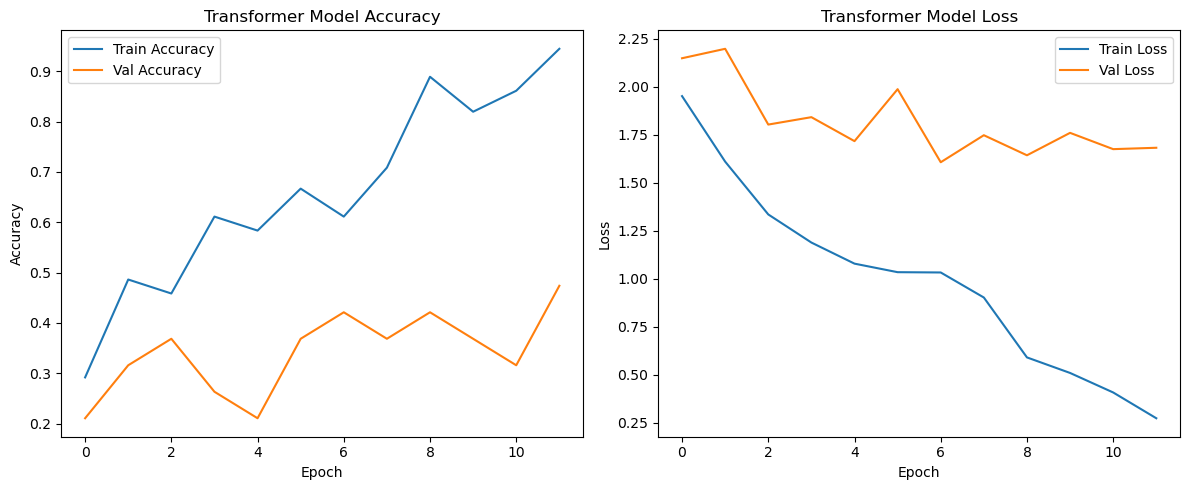

In [24]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Transformer Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Transformer Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


## 11.Confusion Matrix 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step


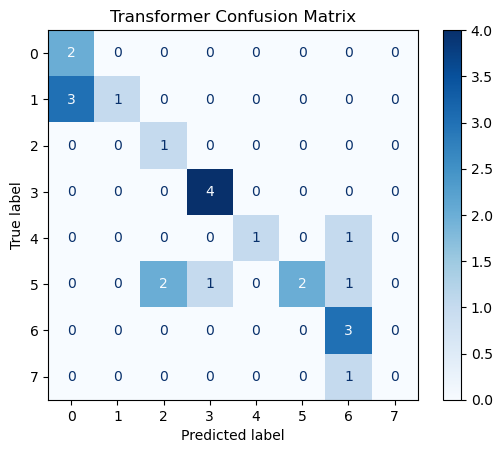

In [26]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Predict classes
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test_encoded, axis=1)

# Confusion matrix
cm = confusion_matrix(y_true_labels, y_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Transformer Confusion Matrix")
plt.show()


## Log Data to a csv file

In [28]:
import csv
from datetime import datetime

# Define what you want to log
log_entry = {
    'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'model': 'Transformer',
    'd_model': 128,
    'num_heads': 4,
    'dropout': 0.3,
    'batch_size': 2,
    'epochs': 50,
    'train_accuracy': history.history['accuracy'][-1],
    'val_accuracy': history.history['val_accuracy'][-1],
    'test_accuracy': accuracy,
    'test_loss': loss
}

# Write to CSV file
log_file = 'transformer_results_log.csv'

# If file doesn't exist, write header
try:
    with open(log_file, 'x', newline='') as f:
        writer = csv.DictWriter(f, fieldnames=log_entry.keys())
        writer.writeheader()
except FileExistsError:
    pass

# Append new result
with open(log_file, 'a', newline='') as f:
    writer = csv.DictWriter(f, fieldnames=log_entry.keys())
    writer.writerow(log_entry)

print(f"Logged result to {log_file}")


Logged result to transformer_results_log.csv


### Future Work:
1. Implement cross-validation strategies for better evaluation.
2. Integrate phase information along with amplitude for improved feature representation.
3. Explore hybrid models (CNN + Transformer) for enhanced learning.
4. Visualize attention weights to interpret model decision-making.
5. Further optimize hyperparameters based on cross-validation results.


The Transformer-based model has demonstrated improvements in capturing long-term dependencies in CSI data, achieving promising results. 
Future experiments will focus on refining model architecture, integrating phase data, and exploring hybrid methods for enhanced feature extraction.
